In [30]:
import os
import sys
import time
import glob
import random
import numpy as np
import pandas as pd
from tqdm import tqdm
from numpy.fft import rfft
from collections import Counter
from pandarallel import pandarallel
from joblib import Parallel, delayed, parallel_backend

import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import Audio

import scipy.signal
import scipy.io.wavfile
from scipy import stats
from scipy.fftpack import fft

import librosa
import librosa.filters
import librosa.display

from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import precision_recall_fscore_support

text_size = 14

plt.rc('font', size=text_size)
plt.rc('axes', titlesize=text_size)
plt.rc('axes', labelsize=text_size)
plt.rc('xtick', labelsize=text_size)
plt.rc('ytick', labelsize=text_size)
plt.rc('legend', fontsize=text_size)
plt.rc('figure', titlesize=text_size)
plt.rcParams['figure.figsize'] = (24, 4)
# plt.rcParams['text.color'] = 'white'
# plt.rcParams['legend.facecolor'] = 'black'
# plt.rcParams['xtick.color'] = 'white'
# plt.rcParams['ytick.color'] = 'white'
# plt.rcParams['axes.labelcolor'] = 'white'
# sns.set_palette(sns.color_palette('muted'));

import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)

In [31]:
debug = True
#pandarallel.initialize(nb_workers=4)
dataPath = '/storage/dataset-APR/fma_dataset-wav/'

wavFileList = glob.glob(dataPath + '*/*.wav')
print('Got', len(wavFileList), 'files')

sampleRate = 22000
monoChannel = True
loadWith = 'librosa'

Got 6917 files


In [32]:
def loadFile(wavPath):
    pathSplit = wavPath.split('/')

    if loadWith == 'scipy':
        datasamplerate, rawdata = scipy.io.wavfile.read(wavPath)
        if monoChannel and len(rawdata.shape)>1:
            rawdata = np.mean(rawdata, axis=1)
        if datasamplerate != sampleRate:
            downsample_n = round(len(rawdata) * float(sampleRate) / datasamplerate)
            rawdata = scipy.signal.resample(rawdata, downsample_n)
        rawdata = np.float32(rawdata)

    if loadWith == 'librosa': #librosa also normalizes the data https://librosa.github.io/librosa/generated/librosa.core.load.html
        rawdata, samplerate = librosa.load(wavPath, sr=sampleRate, mono=monoChannel)

    ### Remove leadind and final zeroes
    rawdata = np.trim_zeros(rawdata)

    filename = pathSplit[-1]
    genre = pathSplit[-2]
    rawdata = rawdata
    return { 'filename': filename, 'genre': genre, 'rawdata': rawdata }

In [33]:
### Generate rolling windows
def rolling_window(data, window_size, overlap_size):
    overlap_size = window_size - overlap_size
    sh = (data.size - window_size + 1, window_size)
    st = data.strides * 2
    view = np.lib.stride_tricks.as_strided(data, strides = st, shape = sh)[0::overlap_size]
    return view#.copy()

window_ms = 25 #64 #25
overlap_ms = 10 #16 #10

window_size  = int(window_ms / 1000 * sampleRate)
overlap_size = int(overlap_ms / 1000 * sampleRate)

In [34]:
### Get sample data for feature explaination
if debug:
    tmp = loadFile(random.choice(wavFileList))
    sample_genre, sample_rawdata = tmp['genre'], tmp['rawdata'][1000:]
    sample_windows = rolling_window(sample_rawdata, window_size, overlap_size)
    sample_window_prev, sample_window = sample_windows[0], sample_windows[1]
    sample_time = time = np.arange(0, sample_rawdata.size) / sampleRate * 1000
    sample_windows_time = rolling_window(sample_time, window_size, overlap_size)
    sample_window_time = sample_windows_time[0]
    left_idx, right_idx = 5, 8

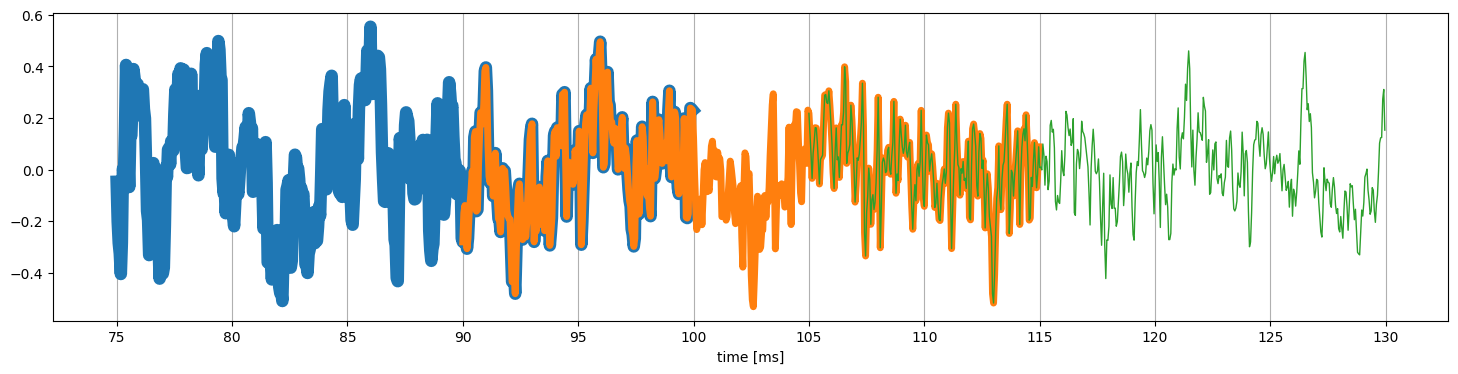

In [35]:
### Explain rolling windows
if debug:
    plt.figure(figsize=(18,4))
    plt.axes().xaxis.grid()
    plt.xlabel('time [ms]')
    lsize = 9
    plt.xticks(np.arange(np.min(sample_windows_time[left_idx:right_idx]), np.max(sample_windows_time[left_idx:right_idx])+1, 5))
    for time, window in list(zip(sample_windows_time[left_idx:right_idx], sample_windows[left_idx:right_idx])):
        plt.plot(time, window, linewidth=lsize)
        lsize -= 4
    plt.show()

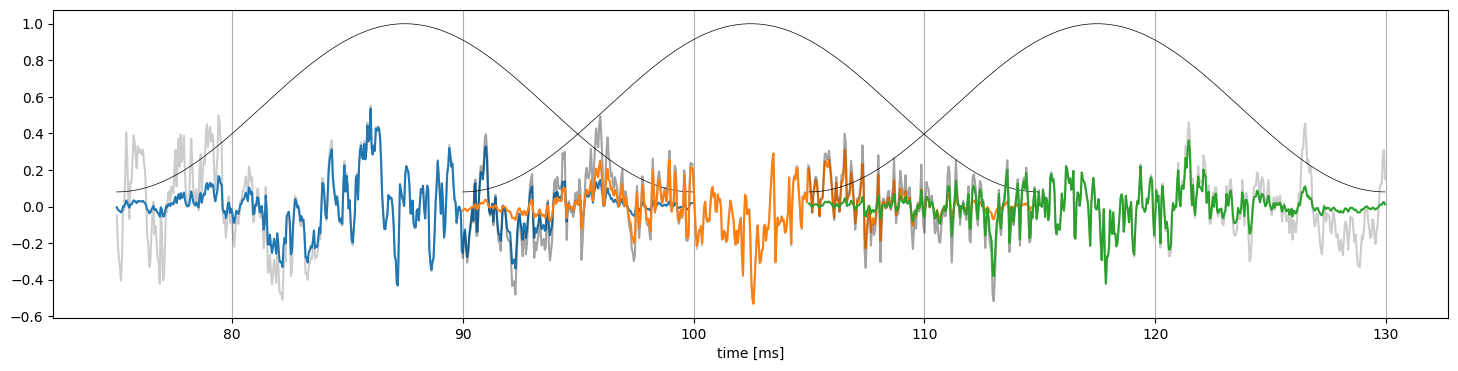

In [36]:
def getHamming(windowSize, alpha=.54, beta=.46):
    #return np.hamming(windowSize)
    hamming = []
    for n in np.arange(0, windowSize):
        h = alpha - beta * np.cos((2 * np.pi * n) / (windowSize -1))
        hamming.append(h)
    return np.array(hamming)

hamming_window = getHamming(window_size)

### Explain hamming
if debug:
    tmp = list(zip(sample_windows_time, sample_windows))[left_idx:right_idx]
    plt.figure(figsize=(18,4))
    plt.axes().xaxis.grid()
    plt.xlabel('time [ms]')
    for time, window in tmp:
        plt.plot(time, hamming_window, linewidth=.5, color='black')
        plt.plot(time, window, color='black', alpha=.2)
        plt.plot(time, window * hamming_window)
    plt.show()

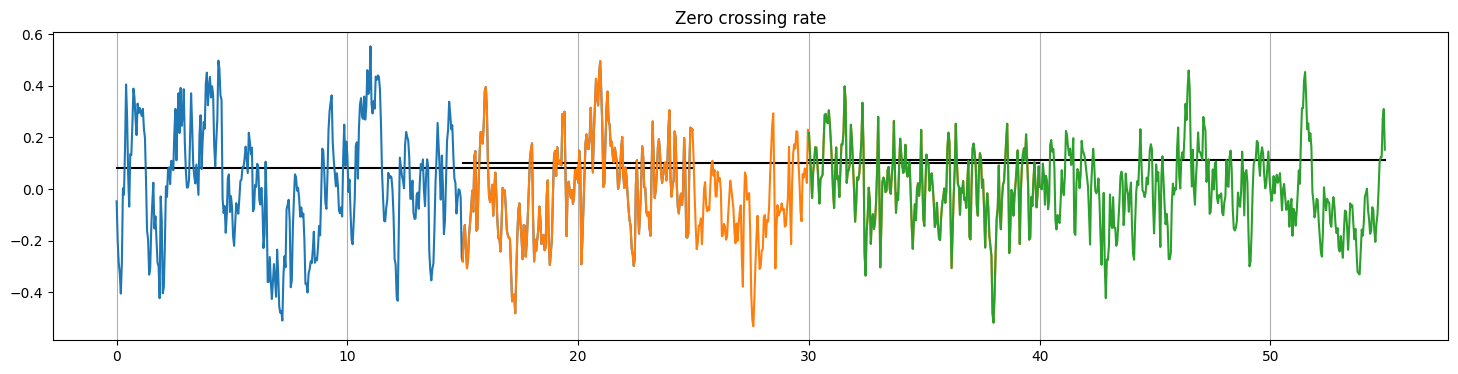

In [37]:
def getZeroCrossingRate(window):
    sign_changes = np.nonzero(np.diff(window > 0))[0]
    rate = sign_changes.size / (2*len(window))
    return rate

if debug:
    plt.figure(figsize=(18,4))
    zeroCrossRates = list(map(getZeroCrossingRate, sample_windows[left_idx:right_idx]))
    tmp = list(zip(sample_windows_time, sample_windows[left_idx:right_idx], zeroCrossRates))
    plt.axes().xaxis.grid()
    plt.title('Zero crossing rate')
    for time, window, zrate in tmp:
        plt.plot(time, [zrate]*len(time), color='black')
        plt.plot(time, window)
    plt.show()

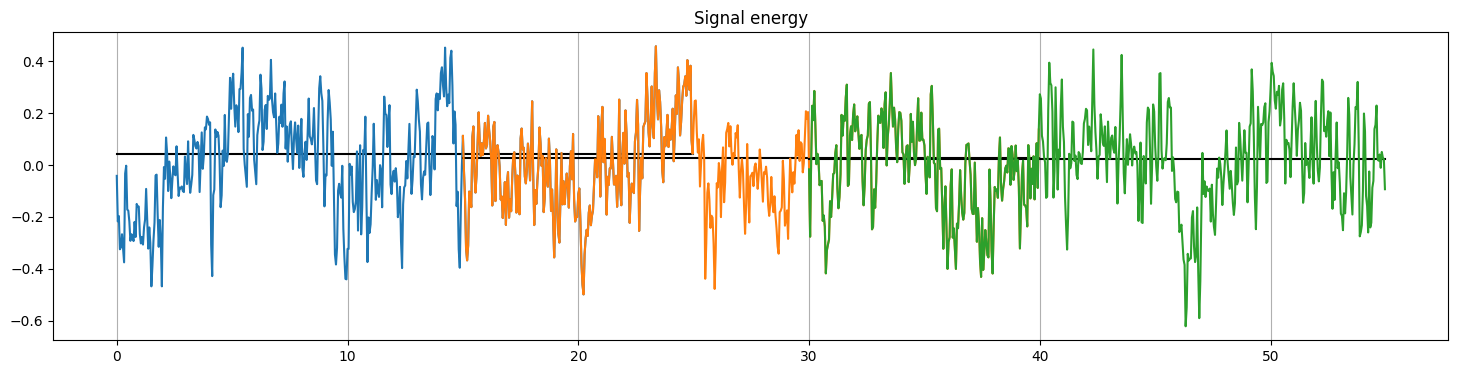

In [38]:
def getSignalEnergy(window):
    power = np.sum(window**2) / len(window)
    return power

if debug:
    energies = list(map(getSignalEnergy, sample_windows[left_idx:right_idx]))
    tmp = list(zip(sample_windows_time, sample_windows, energies))

    plt.figure(figsize=(18,4))
    plt.axes().xaxis.grid();
    plt.title('Signal energy');
    for time, window, energy in tmp:
        plt.plot(time, [energy]*len(time), color='black')
        plt.plot(time, window)
    plt.show()

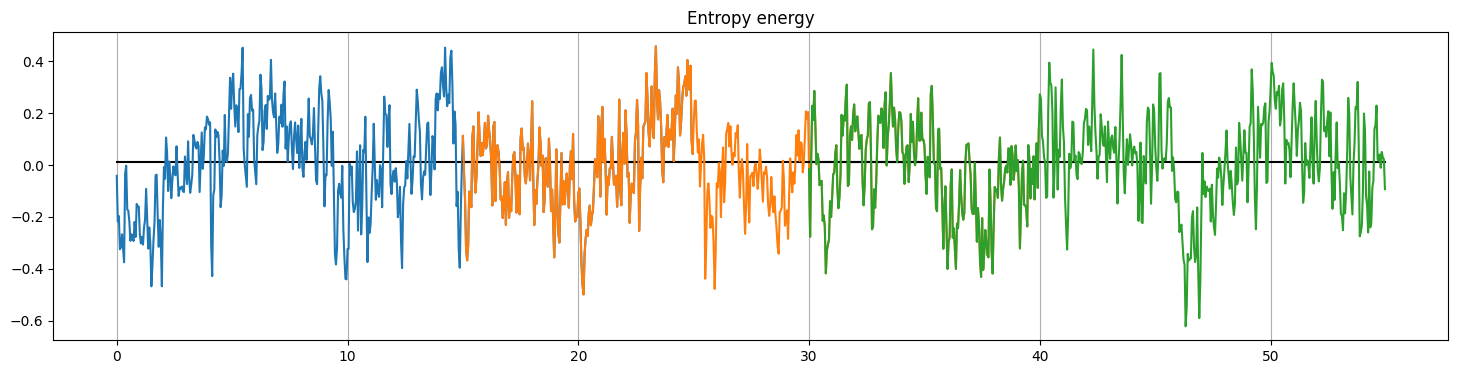

In [39]:
def getEntropyEnergy(window, shortBlocks=10):
    winLength = len(window)
    subWinLength = winLength // shortBlocks
    subWindows = rolling_window(window, subWinLength, 1)

    Eol = sum(window**2)
    s = sum(subWindows**2) / Eol
    Entropy = -sum(s * np.log2(s))
    return Entropy / winLength

if debug:
    energiesG = list(map(getEntropyEnergy, sample_windows[left_idx:right_idx]))
    tmp = list(zip(sample_windows_time, sample_windows, energiesG))

    plt.figure(figsize=(18,4))
    plt.axes().xaxis.grid();
    plt.title('Entropy energy');
    for time, window, energy in tmp:
        plt.plot(time, [energy]*len(time), color='black')
        plt.plot(time, window)
    plt.show()

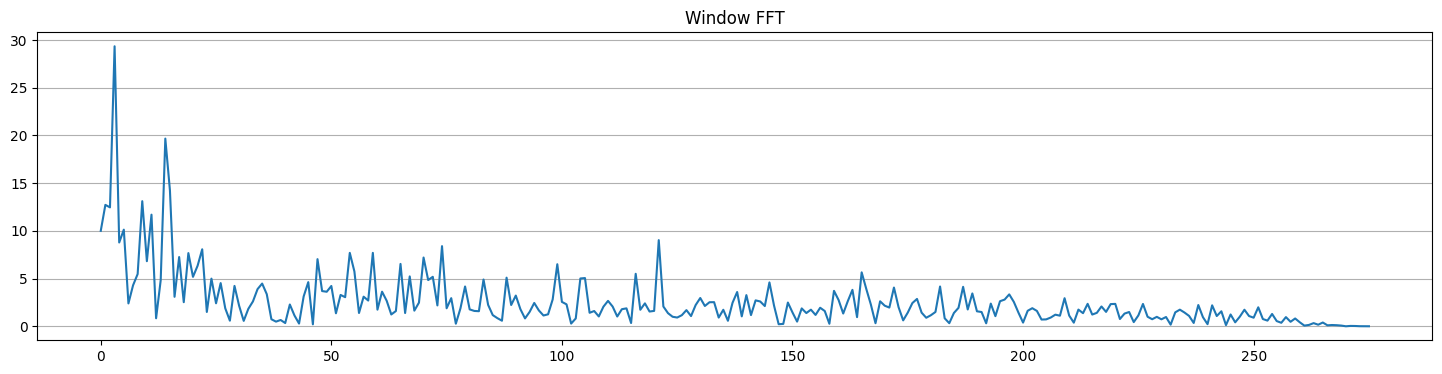

In [40]:
def getFFT(window):
    return abs(np.fft.rfft(window))

if debug:
    sample_windows_fft = list(map(getFFT, sample_windows))
    sample_fft = getFFT(sample_window)
    plt.figure(figsize=(18,4))
    plt.axes().yaxis.grid();
    plt.title('Window FFT');
    plt.plot(sample_fft);
    plt.show()

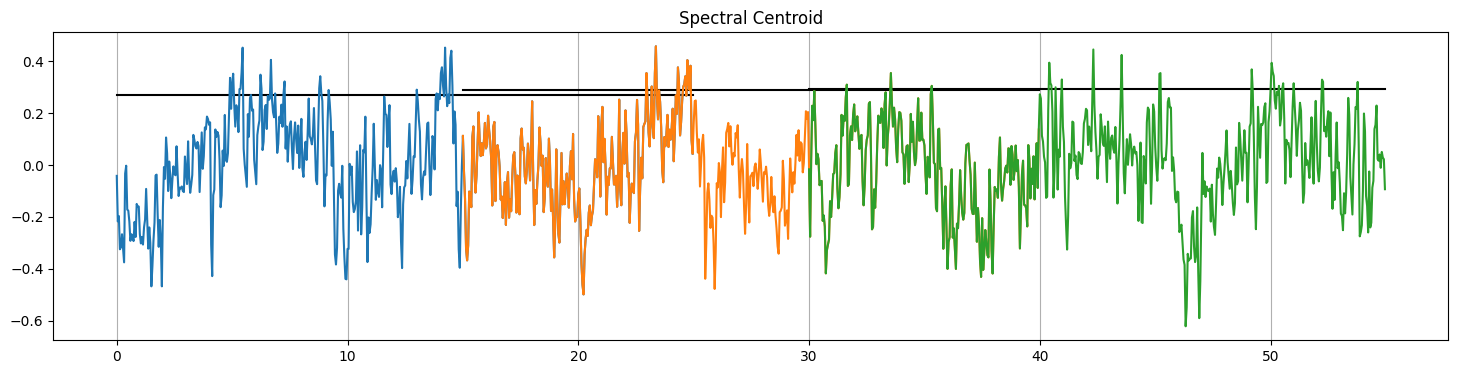

In [41]:
def getSpectralCentroid(windowFFT):
    normalized_spectrum = windowFFT / np.sum(windowFFT)
    normalized_frequencies = np.linspace(0, 1, len(windowFFT))
    spectral_centroid = np.sum(normalized_spectrum * normalized_frequencies)
    return spectral_centroid

if debug:
    spectralCentroids = list(map(getSpectralCentroid, sample_windows_fft[left_idx:right_idx]))
    tmp = list(zip(sample_windows_time, sample_windows, spectralCentroids))
    plt.figure(figsize=(18,4))
    plt.axes().xaxis.grid();
    plt.title('Spectral Centroid');
    for time, window, sc in tmp[:3]:
        plt.plot(time, [sc]*len(time), color='black')
        plt.plot(time, window)
    plt.show()

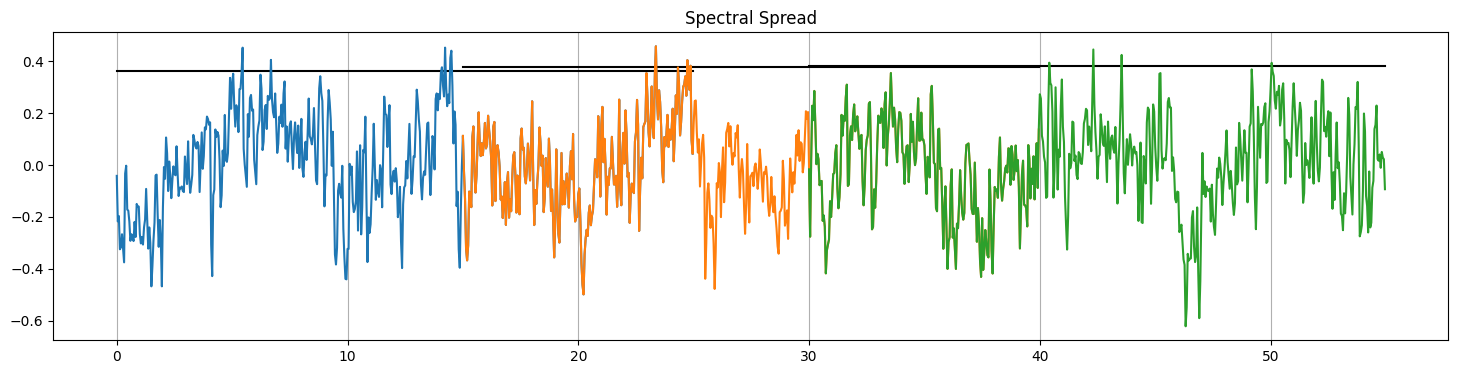

In [42]:
def getSpectralSpread(windowFFT, C):
    windowLength = len(windowFFT)
    m = (sampleRate / (2 * windowLength)) * np.arange(windowLength)
    S = np.sqrt( np.sum( ((m-C)**2) * windowFFT) / np.sum(windowFFT) )
    S = S / (sampleRate/2)
    return S

if debug:
    spectralSpreads = list(map(lambda w: getSpectralSpread(*w), list(zip(sample_windows_fft[left_idx:right_idx], spectralCentroids))))
    tmp = list(zip(sample_windows_time, sample_windows, spectralSpreads))
    plt.figure(figsize=(18,4))
    plt.axes().xaxis.grid();
    plt.title('Spectral Spread');
    for time, window, ss in tmp:
        plt.plot(time, [ss]*len(time), color='black')
        plt.plot(time, window)
    plt.show()

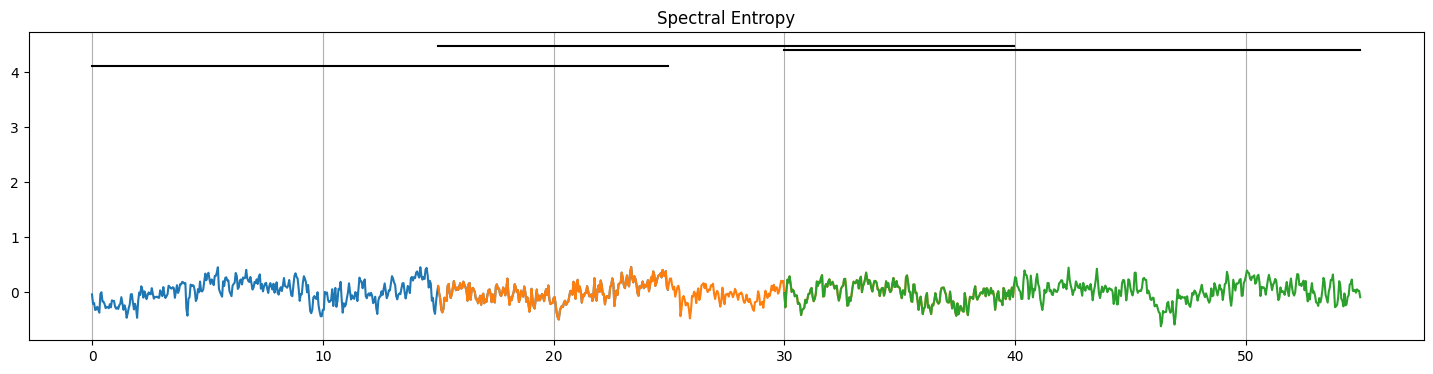

In [43]:
def getSpectralEntropy(windowFFT, n_bins=10):
    winLength = len(windowFFT)
    subWinLength = winLength // n_bins

    subWindows = rolling_window(windowFFT, subWinLength, 1)

    Eol = sum(windowFFT**2)
    s = sum(subWindows**2) / Eol
    Entropy = -sum(s * np.log2(s))
    return Entropy

if debug:
    spectralEntropies = list(map(getSpectralEntropy, sample_windows_fft[left_idx:right_idx]))
    tmp = list(zip(sample_windows_time, sample_windows, spectralEntropies))
    plt.figure(figsize=(18,4))
    plt.axes().xaxis.grid();
    plt.title('Spectral Entropy');
    for time, window, se in tmp:
        plt.plot(time, [se]*len(time), color='black')
        plt.plot(time, window)
    plt.show()

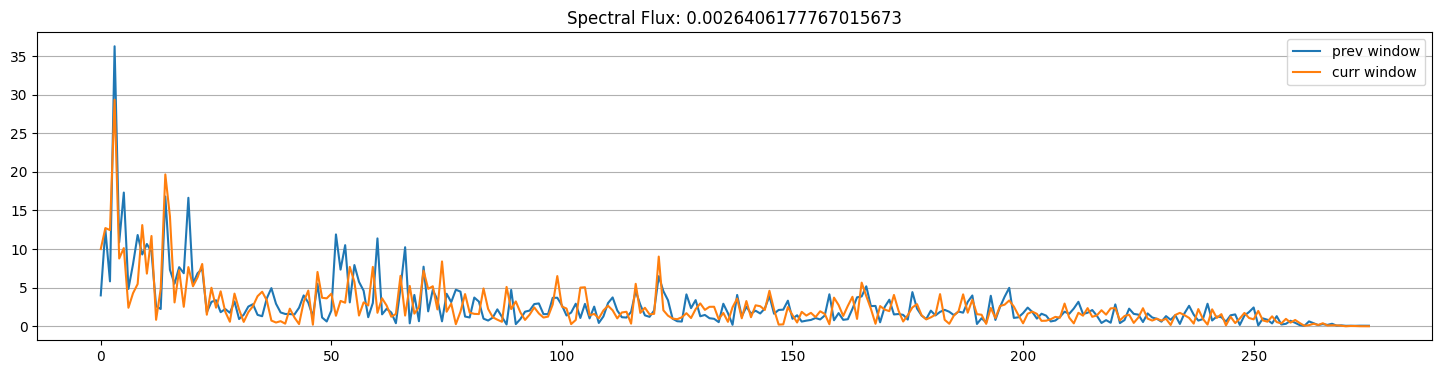

In [44]:
def getSpectralFlux(windowFFT_curr, windowFFT_prev):
    windowFFT_curr = windowFFT_curr / np.sum(windowFFT_curr)
    windowFFT_prev = windowFFT_prev / np.sum(windowFFT_prev)
    flux = np.nansum((windowFFT_curr - windowFFT_prev)**2)
    return flux

if debug:
    sample_fft_prev = getFFT(sample_window_prev)
    spectralFlux = getSpectralFlux(sample_fft_prev, sample_fft)
    plt.figure(figsize=(18,4))
    plt.axes().yaxis.grid();
    plt.title(' '.join(['Spectral Flux:', str(spectralFlux)]));
    plt.plot(sample_fft_prev, label='prev window')
    plt.plot(sample_fft, label='curr window');
    plt.legend();
    plt.show()

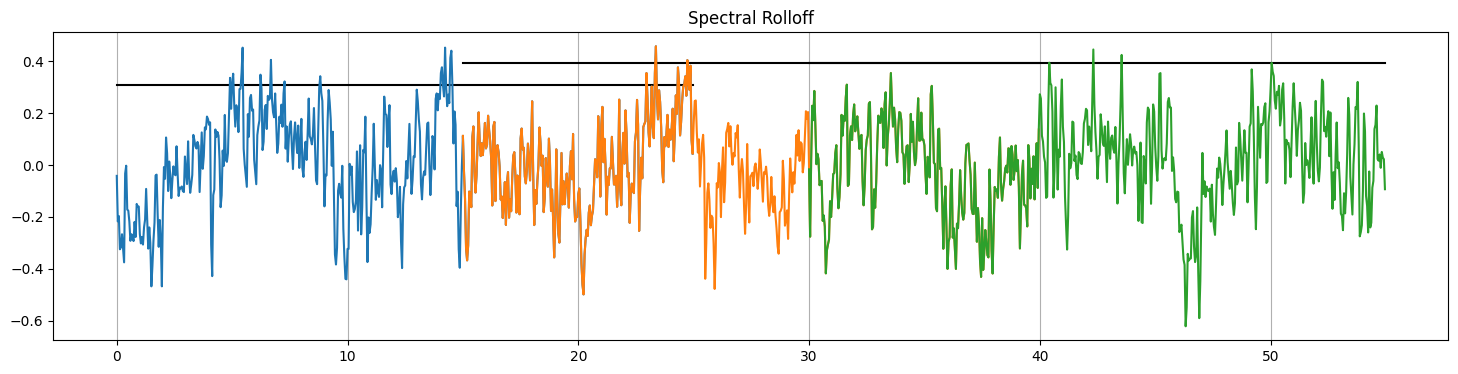

In [45]:
def getSpectralRollOff(windowFFT, c=.90):
    totalEnergy = sum(windowFFT**2)
    curEnergy, countFFT = 0, 1
    fftLength = len(windowFFT)

    while (curEnergy <= c*totalEnergy) and (countFFT<fftLength):
        curEnergy = curEnergy + windowFFT[countFFT]**2
        countFFT = countFFT + 1

    countFFT = countFFT - 1
    mC = (countFFT-1) / fftLength
    return mC

if debug:
    spectralRolloffs = list(map(getSpectralRollOff, sample_windows_fft[left_idx:right_idx]))
    tmp = list(zip(sample_windows_time, sample_windows, spectralRolloffs))
    plt.figure(figsize=(18,4))
    plt.axes().xaxis.grid();
    plt.title('Spectral Rolloff');
    for time, window, sr in tmp:
        plt.plot(time, [sr]*len(time), color='black')
        plt.plot(time, window)
    plt.show()

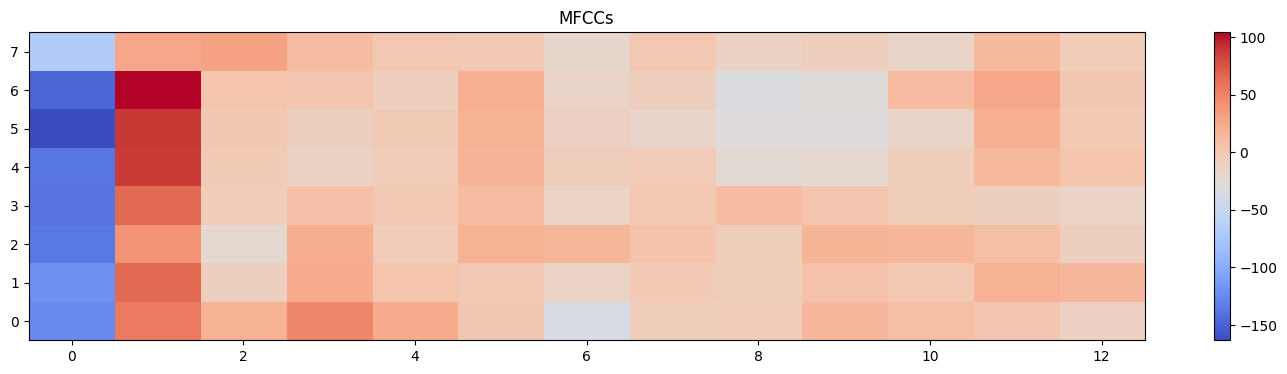

In [46]:
mel_bins = 13
mel_names = list(map(lambda i: 'mel_' + str(i), range(1, mel_bins+1)))   

def getMFCCs(window, num_mfcc=mel_bins, n_fft=2048):
    mfccs = librosa.feature.mfcc(window, sampleRate, n_mfcc=num_mfcc, n_fft=window.size+1, hop_length=window.size+1)
    return mfccs.flatten()

if debug:
    mfccs = list(map(getMFCCs, sample_windows[left_idx:right_idx+5]))
    plt.figure(figsize=(18,4))
    plt.title('MFCCs')
    plt.imshow(mfccs, interpolation='nearest', cmap='coolwarm', origin='lower', aspect='auto');
    plt.colorbar();
    plt.show()

/home/franci/venv3.8/lib/python3.8/site-packages/librosa/core/pitch.py:146: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn('Trying to estimate tuning from empty frequency set.')


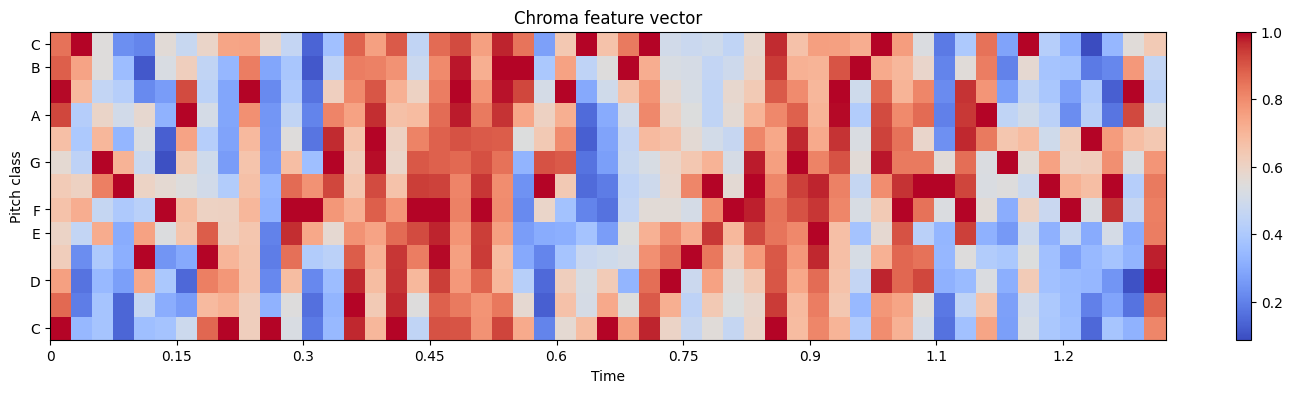

In [47]:
chroma_bins = 13
chroma_names = list(map(lambda i: 'chromabin_' + str(i), range(1, chroma_bins+1)))    

def getChromaVector(window, chroma_bins=chroma_bins, showMe=False):
    chromagram = librosa.feature.chroma_stft(window, sr=sampleRate, n_chroma=chroma_bins, win_length=window.size, hop_length=window.size+1)
    return chromagram.flatten()

if debug:
    chromagram = np.array(list(map(getChromaVector, sample_windows[left_idx+50:right_idx+100]))).T
    plt.figure(figsize=(18,4));
    plt.title('Chroma feature vector')
    librosa.display.specshow(chromagram, x_axis='time', y_axis='chroma', hop_length=window_size, cmap='coolwarm');
    plt.colorbar();
    plt.show();

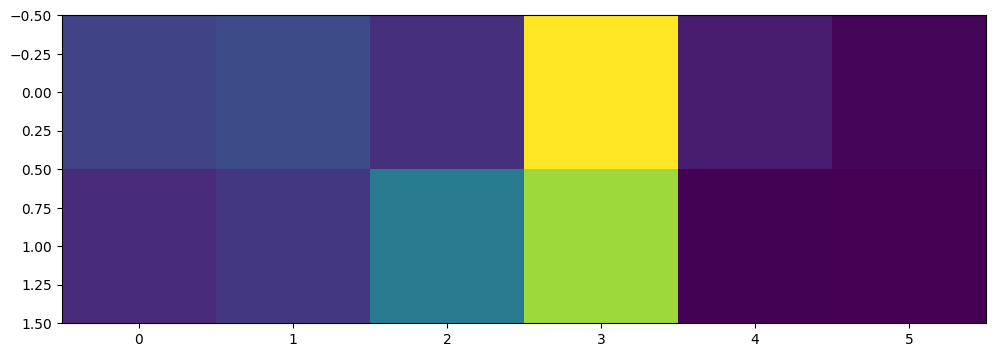

In [48]:
tonnetz_names = ['tonnetz_'+str(i) for i in range(1,7)]

def getTonnetz(window, showMe=False):
    tonnetz = librosa.feature.tonnetz(window, sr=sampleRate)
    return tonnetz if showMe else tonnetz[:,0]

if debug:
    tonnetz = getTonnetz(sample_windows[3], showMe=True).T
    plt.figure(figsize=(18,4));
    plt.imshow(tonnetz);
    plt.show()

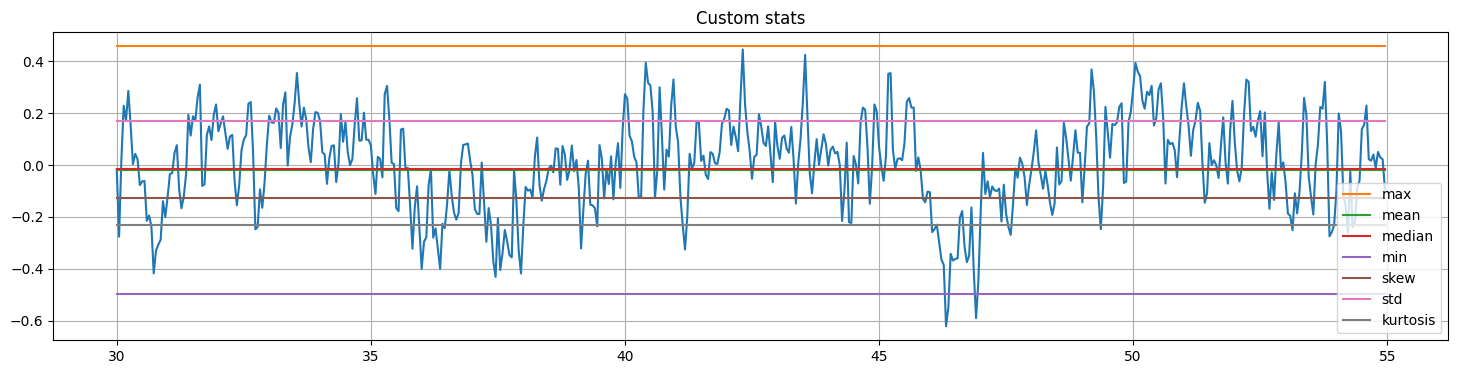

In [49]:
def getStatistics(window):
    stats = list(map(lambda func: func(window), statistics_funcs))
    return np.array(stats)

statistics = [
    ['max', np.max],
    ['mean', np.mean],
    ['median', np.median],
    ['min', np.min],
    ['skew', stats.skew],
    ['std', np.std],
    ['kurtosis', stats.kurtosis]
]

statistics_names, statistics_funcs = zip(*statistics)
statistics_names, statistics_funcs = list(statistics_names), list(statistics_funcs)

if debug:
    sample_window_stats = getStatistics(sample_window)
    plt.figure(figsize=(18,4));
    plt.plot(time, window);
    plt.grid();
    plt.title('Custom stats');
    for statname, value in zip(statistics_names, sample_window_stats):
        plt.plot(time, [value]*len(time), label=statname);
    plt.legend();
    plt.show()

In [24]:
def featurePipeline(filepath, to_csv=True):
    csv_path = output_path + filepath.split('/')[-1] + '.csv'
    if os.path.exists(csv_path): return

    featureSet = pd.DataFrame([loadFile(filepath)])

    featureSet['windows'] = featureSet.rawdata.apply(lambda r: rolling_window(r, window_size, overlap_size))
    featureSet = featureSet.explode('windows')[['filename', 'genre', 'windows']].reset_index()
    featureSet.rename(columns={'windows': 'window'}, inplace=True)

    featureSet['window'] = featureSet.window.apply(lambda window: window * hamming_window)
    featureSet['windowFFT'] = featureSet.apply(lambda e: getFFT(e.window), axis=1)
    featureSet['windowFFT_prev'] = featureSet.groupby('filename')['windowFFT'].shift()

    ### statistics
    featureSet[statistics_names] = featureSet.apply(lambda e: getStatistics(e.window), axis=1, result_type='expand')
    
    ### time-domain features
    featureSet['zero_crossing_rate'] = featureSet.apply(lambda e: getZeroCrossingRate(e.window), axis=1)
    featureSet['energy'] = featureSet.apply(lambda e: getSignalEnergy(e.window), axis=1)
    featureSet['energy_entropy'] = featureSet.apply(lambda e: getEntropyEnergy(e.window), axis=1)

    ### frequency-domain features
    featureSet['spectral_centroid'] = featureSet.apply(lambda e: getSpectralCentroid(e.windowFFT), axis=1)
    featureSet['spectral_spread'] = featureSet.apply(lambda e: getSpectralSpread(e.windowFFT, e.spectral_centroid), axis=1)
    featureSet['spectral_entropy'] = featureSet.apply(lambda e: getSpectralEntropy(e.windowFFT), axis=1)
    featureSet['spectral_rolloff'] = featureSet.apply(lambda e: getSpectralRollOff(e.windowFFT), axis=1)
    featureSet['spectral_flux'] = featureSet.apply(lambda e: getSpectralFlux(e.windowFFT, e.windowFFT_prev), axis=1)
    featureSet[mel_names] = featureSet.apply(lambda e: getMFCCs(e.window), axis=1, result_type='expand')    
    featureSet[chroma_names] = featureSet.apply(lambda e: getChromaVector(e.window), axis=1, result_type='expand')
    featureSet[tonnetz_names] = featureSet.apply(lambda e: getTonnetz(e.window), axis=1, result_type='expand')

    featureSet.drop(['window', 'windowFFT', 'windowFFT_prev'], axis=1, inplace=True)
    if to_csv: featureSet.to_csv(csv_path, index=None)
    else: return featureSet

### Test and profile the pipeline
# from line_profiler import LineProfiler
# output_path = '/storage/dataset-APR/featureset/fma-all-16kHZ/'
# lp = LineProfiler()
# lp_wrapper = lp(featurePipeline)
# df = lp_wrapper(random.choice(wavFileList))
# lp.print_stats()

### Parallel evaluation of features; each wav feature stored in a file
#output_path = '/storage/dataset-APR/featureset/fma-all-16kHZ/'
#output_path = '/storage/dataset-APR/featureset/fma-all-22kHZ/'
#output_path = '/storage/dataset-APR/featureset/fma-all-16kHZ-25ms/'
#output_path = '/storage/dataset-APR/featureset/fma-all-22kHZ-25ms/'
output_path = '/storage/dataset-APR/featureset/fma-all-22kHZ-25ms-allfeat/'
#output_path = '/storage/dataset-APR/featureset/dortmund-audio-all-16kHZ/'
with parallel_backend('loky', inner_max_num_threads=1):
    Parallel(n_jobs=10, verbose=1)(delayed(featurePipeline)(wav) for wav in wavFileList)

[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    2.0s
[Parallel(n_jobs=10)]: Done 1982 tasks      | elapsed:    3.1s
[Parallel(n_jobs=10)]: Done 6917 out of 6917 | elapsed: 105.6min finished


In [22]:
### Load feature set and average windows
msToAverage = 2000
howManyWindowAverage = msToAverage // (window_ms - overlap_ms) #-> actually every window steps over 15ms because of overlapping
print('averaging n window:', howManyWindowAverage)

#all_files = glob.glob('/storage/dataset-APR/featureset/fma-all-16kHZ/*.csv')
#all_files = glob.glob('/storage/dataset-APR/featureset/fma-all-22kHZ-64ms/*.csv')
#all_files = glob.glob('/storage/dataset-APR/featureset/fma-all-22kHZ-25ms/*.csv')
all_files = glob.glob('/storage/dataset-APR/featureset/fma-all-22kHZ-25ms-allfeat/*.csv')
#all_files = glob.glob('/storage/dataset-APR/featureset/dortmund-audio-all-16kHZ/*.csv')
#all_files = glob.glob('/storage/dataset-APR/featureset/dortmund-audio-all-22kHZ/*.csv')

li = []
for filename in tqdm(all_files):
    df = pd.read_csv(filename, index_col=None)
    df = df.groupby(['filename', 'genre', np.arange(len(df.index)) // howManyWindowAverage]).mean().reset_index()
    df.drop(['index', 'level_0', 'level_2'], inplace=True, axis=1, errors='ignore')
    li.append(df)

featureSet = pd.concat(li, axis=0, ignore_index=True)
#featureSet.to_csv('/storage/dataset-APR/featureset/fma-all-16kHZ-'+str(msToAverage)+'ms.csv', header=True, index=False)
#featureSet.to_csv('/storage/dataset-APR/featureset/fma-all-22kHZ-'+str(msToAverage)+'ms.csv', header=True, index=False)
#featureSet.to_csv('/storage/dataset-APR/featureset/fma-all-22kHZ-64ms-'+str(msToAverage)+'ms.csv', header=True, index=False)
featureSet.to_csv('/storage/dataset-APR/featureset/fma-all-22kHZ-25ms-'+str(msToAverage)+'ms-allfeat.csv', header=True, index=False)
#featureSet.to_csv('/storage/dataset-APR/featureset/dortmund-audio-all-22kHZ-'+str(msToAverage)+'ms.csv', header=True, index=False)

  0%|          | 3/6911 [00:00<04:39, 24.70it/s]

averaging n window: 133


100%|██████████| 6911/6911 [08:32<00:00, 13.50it/s]


### Models evaluation

In [51]:
def getMajority(pred):
    return Counter(pred).most_common(1)[0][0]

def getConfusionMatrix(title, y_test, y_pred):
    cm = pd.DataFrame(confusion_matrix(y_pred, y_test, labels=labels))
    cm.rename(columns=to_label, index=to_label, inplace=True)
    plt.figure(figsize=(9, 7))
    plt.title(title)
    ax = sns.heatmap(cm, annot=True, cmap='cividis_r', cbar=False, fmt='g')
    ax.set(xlabel='label', ylabel='prediction')
    return cm

def getPRFstats(y_test, y_pred, plot=True):
    acc = metrics.accuracy_score(y_test, y_pred)
    prec, recall, f1 = precision_recall_fscore_support(y_test, y_pred, average='micro')[:-1]

    res = zip(['accuracy','precision','recall','f1score:'], map(lambda n: str(round(n, 2)), [acc,prec,recall,f1]))
    print('Overall stats', *map(lambda r: ': '.join(r), res), sep='\n  ')

    if not plot: return
    prf = classification_report(y_test, y_pred, target_names=labels, output_dict=True)
    keysToRemove = set(prf.keys()) - set(labels)
    for key in keysToRemove: del prf[key]
    prf = pd.DataFrame(prf).T.drop('support', axis=1).round(2)
    prf['sum'] = prf.sum(axis=1)
    prf = prf.sort_values(by='sum', ascending=False).drop('sum', axis=1)
    plt.figure(figsize=(5, 7));
    sns.heatmap(np.round(prf,2), annot=True, cmap='Blues', cbar=False, fmt='g');

def getMajorityLabel(df, y_pred):
    ### Apply majority to window predictions results
    df_majority = df.copy()
    df_majority['prediction'] = y_pred
    df_majority = df_majority.merge(featureSet, how='left', left_index=True, right_index=True)
    df_majority = df_majority.groupby(['filename', 'genre'])['prediction'].apply(getMajority).reset_index()
    return df_majority

In [52]:
### Import data
featureSet = pd.read_csv('/storage/dataset-APR/featureset/fma-all-22kHZ-25ms-2000ms-allfeat.csv').dropna()

### Feature name, label name
keysToDrop = ['filename', 'genre']
featureNames = list(filter(lambda c: c not in keysToDrop, featureSet.keys()))

targetName = 'genre'
labels = featureSet[targetName].unique().tolist()
to_label = dict(enumerate(labels))

featureSet

,filename,genre,max,mean,median,min,skew,std,kurtosis,zero_crossing_rate,...,chromabin_10,chromabin_11,chromabin_12,chromabin_13,tonnetz_1,tonnetz_2,tonnetz_3,tonnetz_4,tonnetz_5,tonnetz_6
0,026583.wav,experimental,0.149069,0.000597,0.000373,-0.147201,0.014319,0.049412,1.014342,0.035468,...,0.106185,0.075948,0.079492,0.125244,0.013250,-0.016195,0.000102,0.018455,-0.007368,-0.019346
1,026583.wav,experimental,0.174913,0.000308,0.000324,-0.181559,-0.037634,0.060948,1.037863,0.021217,...,0.466369,0.467266,0.379835,0.288678,0.001606,-0.013208,-0.009658,0.030282,0.006598,-0.001174
2,026583.wav,experimental,0.155180,0.000177,0.000091,-0.150576,0.061603,0.054669,0.906140,0.018353,...,0.363242,0.399392,0.381290,0.383310,-0.002683,-0.013847,-0.012760,0.026506,-0.000993,-0.007513
3,026583.wav,experimental,0.117029,0.000149,0.000099,-0.114480,0.040628,0.048285,0.097924,0.012727,...,0.142576,0.209812,0.307050,0.423031,0.010250,-0.000639,0.015037,0.022851,-0.011257,-0.008911
4,026583.wav,experimental,0.221621,0.000249,0.000140,-0.222522,0.006374,0.076707,0.774333,0.026370,...,0.393159,0.189425,0.146299,0.204266,0.006351,-0.007480,0.010705,0.034217,0.001973,-0.006471
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110555,149185.wav,electronic,0.315319,0.000010,0.001042,-0.329191,-0.097980,0.105764,1.458419,0.029897,...,0.380558,0.407064,0.311010,0.213073,-0.005943,-0.014806,0.013392,0.015649,-0.009101,-0.011961
110556,149185.wav,electronic,0.252849,-0.000017,-0.001103,-0.240087,0.116449,0.080536,1.687545,0.023254,...,0.607898,0.722497,0.610879,0.390702,0.010559,-0.031622,0.048444,0.057654,-0.002013,-0.021895
110557,149185.wav,electronic,0.436805,-0.000015,-0.000465,-0.439576,0.033143,0.128885,1.704083,0.072262,...,0.545713,0.589942,0.542854,0.549028,0.007233,-0.024576,0.048989,0.060705,-0.000902,-0.012357
110558,149185.wav,electronic,0.551991,-0.000089,-0.000507,-0.560475,0.011953,0.155755,1.784269,0.115024,...,0.455822,0.481615,0.406710,0.342739,0.006210,0.007130,0.004475,0.048611,-0.011369,-0.020639


In [58]:
# from dataprep.eda import plot as edaplot
# plt.figure(figsize=(3,3))
# edaplot(featureSet.drop('filename', axis=1))

In [ ]:
#sns.pairplot(featureSet[featureNames].sample(1000), hue='genre')

In [59]:
### MedFilt
featureSet[featureNames] = scipy.signal.medfilt(featureSet[featureNames])

In [244]:
### Train/test split for model evaluation
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    featureSet[featureNames],
    featureSet[targetName],
    stratify = featureSet['genre'],
    test_size = .2)

In [61]:
### CrossValidation folds
from sklearn.model_selection import StratifiedKFold
kfold_splits = StratifiedKFold(n_splits = 10)
kfold_splits = kfold_splits.split(featureSet[featureNames], featureSet[targetName])
kfold_splits = list(kfold_splits) # it's a generator and we want to use the same splits among all the classification

In [62]:
### Grouping features
statFeatures = [
    'max', 'mean', 'median', 'min', 'skew', 'std', 'kurtosis'
]

spectralFeatures = [
    'spectral_centroid', 'spectral_spread', 'spectral_entropy', 'spectral_rolloff', 'spectral_flux',
    'mel_1', 'mel_2', 'mel_3', 'mel_4', 'mel_5', 'mel_6', 'mel_7', 'mel_8', 'mel_9', 'mel_10', 'mel_11', 'mel_12', 'mel_13',
    'chromabin_1', 'chromabin_2', 'chromabin_3', 'chromabin_4', 'chromabin_5', 'chromabin_6', 'chromabin_7', 'chromabin_8', 'chromabin_9', 'chromabin_10', 'chromabin_11', 'chromabin_12', 'chromabin_13',
    'tonnetz_1', 'tonnetz_2', 'tonnetz_3', 'tonnetz_4', 'tonnetz_5', 'tonnetz_6'
]

temporalFeatures = [
    'zero_crossing_rate', 'energy', 'energy_entropy'
]

allFeatures = statFeatures + spectralFeatures + temporalFeatures

feature_evaluations = list(zip(['SpectralFeatures', 'TemporalFeatures', 'AllFeatures'], [spectralFeatures, temporalFeatures, allFeatures]))

### KMeans

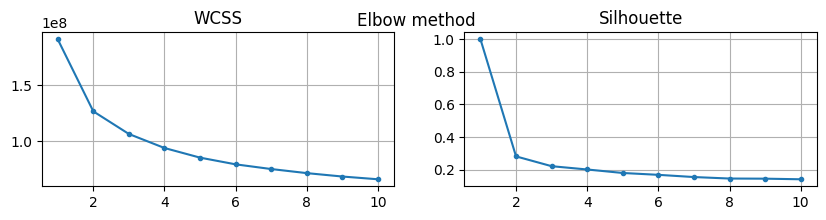

In [76]:
### KMeans WCSS/Inertia/ElbowMethod
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

num_clusters = np.arange(1, 11)
wcss, sils = [], []

for num_cluster in tqdm(num_clusters):
    kmeans = KMeans(
        n_clusters = num_cluster,
        max_iter = 100,
        n_init = 10,
        tol = 10**-5
    )
    kmeans.fit(featureSet[featureNames])
    
    ### Sum of squared distances of samples to their closest cluster center.
    wcss.append(kmeans.inertia_)
    ### Silhouette
    if num_cluster > 1: sil = sils.append(silhouette_score(featureSet[featureNames], kmeans.labels_, metric = 'euclidean', sample_size=5000))
    else: sils.append(1)

### Elbow method
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,2))
fig.suptitle('Elbow method')
ax1.set_title('WCSS')
ax1.plot(num_clusters, wcss, '.-');
ax1.xlabel, ax1.ylabel = 'n_cluster', 'wcss'
ax1.grid()
ax2.set_title('Silhouette')
ax2.plot(num_clusters, sils, '.-');
ax2.xlabel, ax2.ylabel = 'n_cluster', 'silhouette'
ax2.grid()
plt.show()

In [68]:
### KMeans with optimal n-cluster parameter
from sklearn.cluster import KMeans

kmeans = KMeans(
    n_clusters = 2, #len(labels),
    max_iter = 100,
    n_init = 10,
    tol = 10**-4
)
kmeans.fit(featureSet[featureNames])

### Use KMean cluster as a feature
featureSet['kcluster'] = kmeans.labels_
allFeatures.append('kcluster')

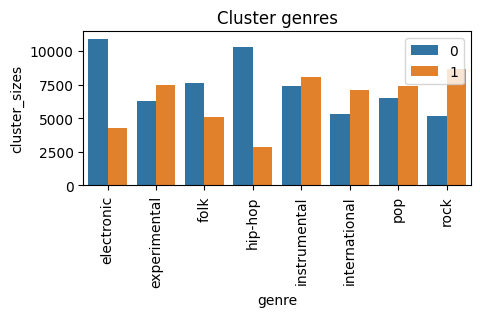

In [98]:
### Group cluster labels and plot counts, to visualize cluster discriminance
plt.figure(figsize=(5, 2))
grp = featureSet[['genre', 'kcluster']].reset_index().groupby(['genre', 'kcluster']).count().reset_index()
plt.title('Cluster genres');
sns.barplot(x='genre', y='cluster_sizes', hue='kcluster', data=grp.rename(columns={'index': 'cluster_sizes'}));
plt.legend(loc='upper right');
plt.xticks(rotation=90);
plt.show()

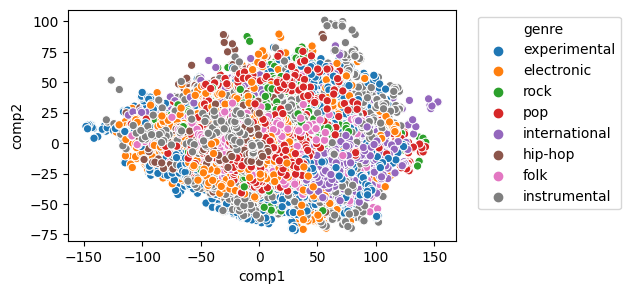

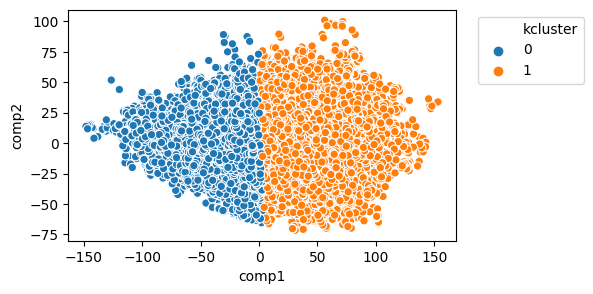

In [112]:
### PCA
from sklearn.decomposition import PCA

reduced_data = PCA(n_components=2).fit_transform(featureSet[featureNames])
df = pd.DataFrame(reduced_data, columns=['comp1', 'comp2'])
#df['kcluster'] = featureSet.kcluster
df['genre'] = featureSet.genre
plt.figure(figsize=(5, 3));
sns.scatterplot(x='comp1', y='comp2', hue='genre', data=df);
plt.legend(bbox_to_anchor=(1.04,1), loc='upper left')
plt.plot();
#plt.show();

df['kcluster'] = featureSet.kcluster
plt.figure(figsize=(5, 3));
sns.scatterplot(x='comp1', y='comp2', hue='kcluster', data=df);
plt.legend(bbox_to_anchor=(1.04,1), loc='upper left')
plt.plot();
plt.show();

### Random Forest

In [17]:
### RandomForestClassifier hyperparameter search
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

param_grid = {
    'criterion': ['gini', 'entropy'],
    'n_estimators': [100, 250, 333],
    'max_depth': [25, None],
    'max_features': [15, 'auto'],
    'min_samples_split': [2, 10],
    'class_weight': ['balanced', 'balanced_subsample']
}

clf_rf = RandomForestClassifier()

clf_rf_rscv = GridSearchCV(
    estimator = clf_rf,
    param_grid = param_grid,
    cv = 2,
    n_jobs = 5,
    verbose = 2
)

clf_rf_rscv.fit(X_train, y_train)
print('Best params:', clf_rf_rscv.best_params_)

{'criterion': 'entropy', 'max_depth': 25, 'max_features': 15, 'n_estimators': 333, 'min_samples_split': 2, 'class_weight': 'balanced'}


In [113]:
### RandomForestClassifier CrossValidation
from sklearn.ensemble import RandomForestClassifier

clf_rf = RandomForestClassifier(**{
    'criterion': 'entropy',
    'max_depth': 25,
    'max_features': 'auto',
    'n_estimators': 333,
    'min_samples_split': 2,
    'class_weight': 'balanced',
    'n_jobs': 6
})

evaluation_scores = []
for features_type, features_to_use in feature_evaluations:
    print('Cross validation with', features_type, end='')
    for fold_n, (train_idx, test_idx) in tqdm(list(enumerate(kfold_splits))):
        
        X_train, y_train = featureSet[features_to_use].iloc[train_idx], featureSet[targetName].iloc[train_idx]
        X_test, y_test = featureSet[features_to_use].iloc[test_idx], featureSet[targetName].iloc[test_idx]

        ### Fold evaluation
        clf_rf.fit(X_train, y_train)
        y_pred = clf_rf.predict(X_test)
        
        ### Apply majority to window labels
        df_majority = X_test.copy()
        df_majority['prediction'] = y_pred
        df_majority = df_majority.merge(featureSet, how='left', left_index=True, right_index=True)
        df_majority = df_majority.groupby(['filename', 'genre'])['prediction'].apply(getMajority).reset_index()
        
        maj_crep = metrics.classification_report(df_majority.genre, df_majority.prediction, target_names=labels, output_dict=True, digits=3)
        fold_evaluation = {'set': features_type, 'fold_n': fold_n, 'genre': 'all', 'score': 'accuracy', 'value': maj_crep['accuracy']}
        evaluation_scores.append(fold_evaluation)
        
        for genre in labels:
            for score in maj_crep[genre]:
                if score == 'support': continue
                fold_evaluation = {'set': features_type, 'fold_n': fold_n, 'genre': genre, 'score': score, 'value': maj_crep[genre][score]}      
                evaluation_scores.append(fold_evaluation)

evaluation_scores = pd.DataFrame(evaluation_scores)
evaluation_scores = evaluation_scores.groupby(['set', 'genre', 'score']).mean().reset_index()

  0%|          | 0/10 [00:00<?, ?it/s]

Cross validation with SpectralFeatures

  0%|          | 0/10 [00:00<?, ?it/s]

Cross validation with TemporalFeatures

  0%|          | 0/10 [00:00<?, ?it/s]

Cross validation with AllFeatures

100%|██████████| 10/10 [13:34<00:00, 81.44s/it]


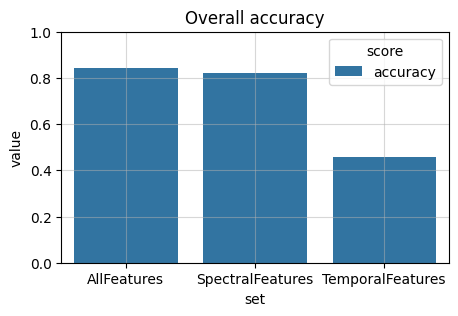

In [158]:
plt.figure(figsize=(5,3))
plt.title('Overall accuracy');
sns.barplot(x='set', y='value', hue='score', data=evaluation_scores[evaluation_scores.score == 'accuracy'])
plt.grid(alpha=.5);
plt.ylim(0, 1)
plt.show()

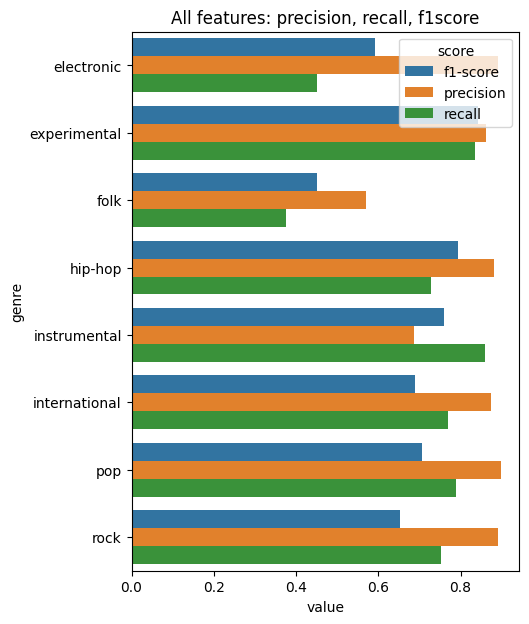

In [176]:
### All features, precision/recall/f1score
plt.figure(figsize=(5,7));
plt.title('All features: precision, recall, f1score');
sns.barplot(x='value', y='genre', hue='score', data=data); #evaluation_scores[(evaluation_scores.set=='AllFeatures') & (evaluation_scores.genre != 'all')]
plt.show()

In [179]:
# ### RandomForestClassifier
# from sklearn.ensemble import RandomForestClassifier

# clf_rf = RandomForestClassifier(**{
#     'criterion': 'entropy',
#     'max_depth': 25,
#     'max_features': 15,
#     'n_estimators': 333,
#     'min_samples_split': 2,
#     'class_weight': 'balanced',
#     'n_jobs': 6
# })

# clf_rf = clf_rf.fit(X_train, y_train)
# y_pred = clf_rf.predict(X_test)

# df_majority = getMajorityLabel(X_test, y_pred)

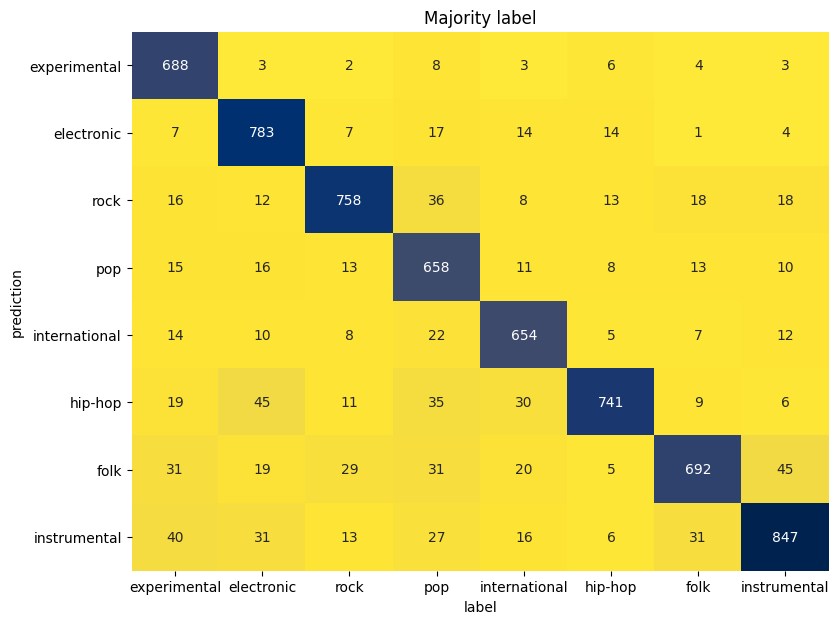

In [143]:
### Last fold CF
getConfusionMatrix('Majority label', df_majority.genre, df_majority.prediction)

Overall stats
  accuracy: 0.87
  precision: 0.87
  recall: 0.87
  f1score:: 0.87


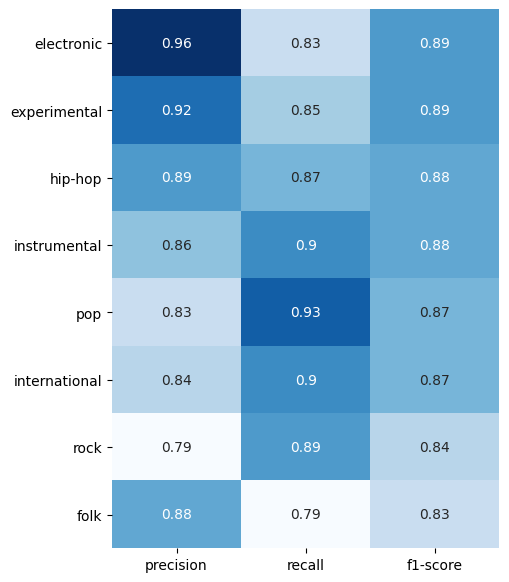

In [184]:
### Last fold stats
getPRFstats(df_majority.genre, df_majority.prediction)

### MultiLayer Perceptron

In [185]:
### MultiLayerPerceptron hyperparameter search
from sklearn.model_selection import GridSearchCV

param_grid = {
    'solver': ['adam', 'lbfgs', 'sgd', 'adam'],
    'hidden_layer_sizes': [50, (100, 50, 50)],
    'max_iter': [100, 500],
    'activation': ['identity', 'logistic', 'tanh', 'relu'],
}

clf_mlp = MLPClassifier()

clf_mlp_rscv = GridSearchCV(
    estimator = clf_mlp,
    param_grid = param_grid,
    cv = 2,
    n_jobs = 5,
    verbose = 2
)

clf_mlp_rscv.fit(X_train, y_train)
print('Best params:', clf_mlp_rscv.best_params_)

Best params: {'solver': 'lbfgs', 'hidden_layer_sizes': 50, 'max_iter': 50, 'activation': 'identity'}


In [186]:
### MLP CrossValidation
from sklearn.neural_network import MLPClassifier

clf_mlp = MLPClassifier(**{
    'solver': 'lbfgs',
    'hidden_layer_sizes': 50,
    'max_iter': 50,
    'activation': 'identity',
    'verbose': 0
})

evaluation_scores = []
for features_type, features_to_use in feature_evaluations:
    print('Cross validation with', features_type, end='')
    for fold_n, (train_idx, test_idx) in tqdm(list(enumerate(kfold_splits))):
        
        X_train, y_train = featureSet[features_to_use].iloc[train_idx], featureSet[targetName].iloc[train_idx]
        X_test, y_test = featureSet[features_to_use].iloc[test_idx], featureSet[targetName].iloc[test_idx]

        ### Fold evaluation
        clf_mlp.fit(X_train, y_train)
        y_pred = clf_mlp.predict(X_test)
        
        ### Apply majority to window labels
        df_majority = X_test.copy()
        df_majority['prediction'] = y_pred
        df_majority = df_majority.merge(featureSet, how='left', left_index=True, right_index=True)
        df_majority = df_majority.groupby(['filename', 'genre'])['prediction'].apply(getMajority).reset_index()
        
        maj_crep = metrics.classification_report(df_majority.genre, df_majority.prediction, target_names=labels, output_dict=True, digits=3)
        fold_evaluation = {'set': features_type, 'fold_n': fold_n, 'genre': 'all', 'score': 'accuracy', 'value': maj_crep['accuracy']}
        evaluation_scores.append(fold_evaluation)
        
        for genre in labels:
            for score in maj_crep[genre]:
                if score == 'support': continue
                fold_evaluation = {'set': features_type, 'fold_n': fold_n, 'genre': genre, 'score': score, 'value': maj_crep[genre][score]}      
                evaluation_scores.append(fold_evaluation)

evaluation_scores = pd.DataFrame(evaluation_scores)
evaluation_scores = evaluation_scores.groupby(['set', 'genre', 'score']).mean().reset_index()

  0%|          | 0/10 [00:00<?, ?it/s]

Cross validation with SpectralFeatures

/home/franci/venv3.8/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:471: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
 10%|█         | 1/10 [00:07<01:03,  7.11s/it]/home/franci/venv3.8/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:471: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
 20%|██        | 2/10 [00:14<00:56,  7.09s/it]/home/franci/venv3.8/lib/python3.8/site-packages/sklearn/neural_network/

Cross validation with TemporalFeatures

/home/franci/venv3.8/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:471: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/franci/venv3.8/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
 10%|█         | 1/10 [00:07<01:08,  7.66s/it]/home/franci/venv3.8/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:471: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase 

Cross validation with AllFeatures

/home/franci/venv3.8/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:471: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
 10%|█         | 1/10 [00:08<01:14,  8.24s/it]/home/franci/venv3.8/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:471: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
 20%|██        | 2/10 [00:16<01:05,  8.16s/it]/home/franci/venv3.8/lib/python3.8/site-packages/sklearn/neural_network/

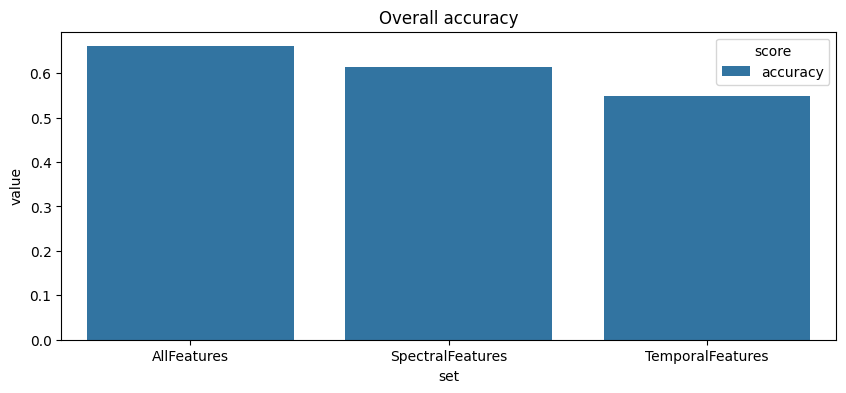

In [238]:
plt.figure(figsize=(10,4))
plt.title('Overall accuracy');
sns.barplot(x='set', y='value', hue='score', data=data)#evaluation_scores[evaluation_scores.score == 'accuracy']);
plt.show()

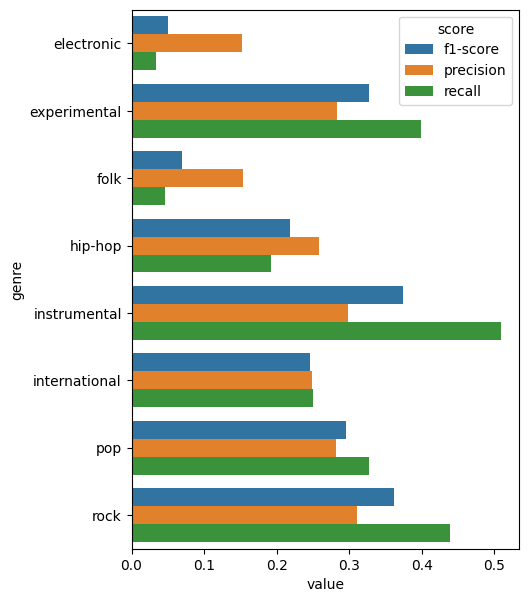

In [243]:
# All features, precision, recall, f1score
data = evaluation_scores[(evaluation_scores.set=='AllFeatures') & (evaluation_scores.genre != 'all')]
plt.figure(figsize=(5, 7));
sns.barplot(x='value', y='genre', hue='score', data=data)#evaluation_scores[(evaluation_scores.set=='AllFeatures') & (evaluation_scores.genre != 'all')]);
plt.show()

In [250]:
clf_mlp = MLPClassifier(**{
    'solver': 'adam',
    'hidden_layer_sizes': (100,50),
    'max_iter': 500,
    'activation': 'relu',
    'verbose': 0
})
clf_mlp = clf_mlp.fit(X_train, y_train)
y_pred = clf_mlp.predict(X_test)

df_majority = getMajorityLabel(X_test, y_pred)

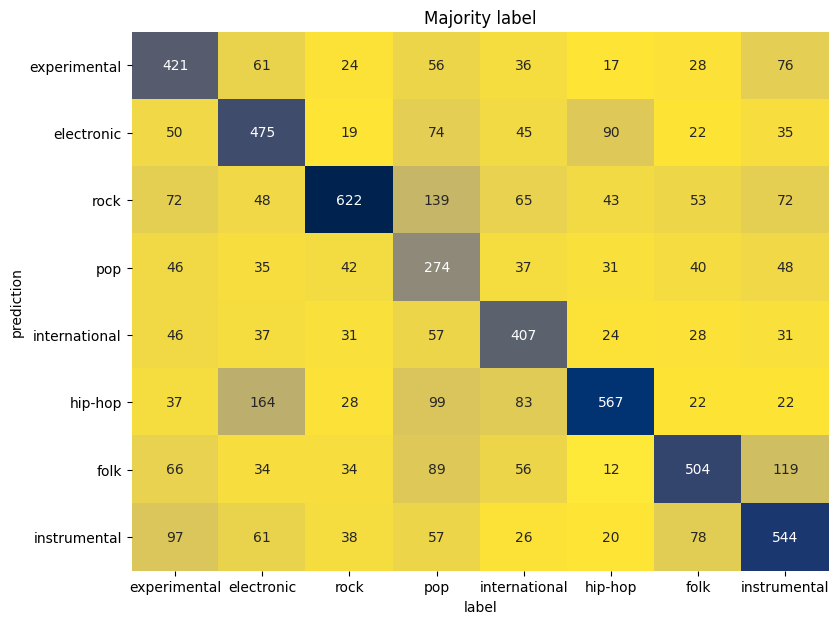

In [257]:
### Last fold classification - apply majority to window predictions results
getConfusionMatrix('Majority label', df_majority.genre, df_majority.prediction)
plt.show()

Overall stats
  accuracy: 0.57
  precision: 0.57
  recall: 0.57
  f1score:: 0.57


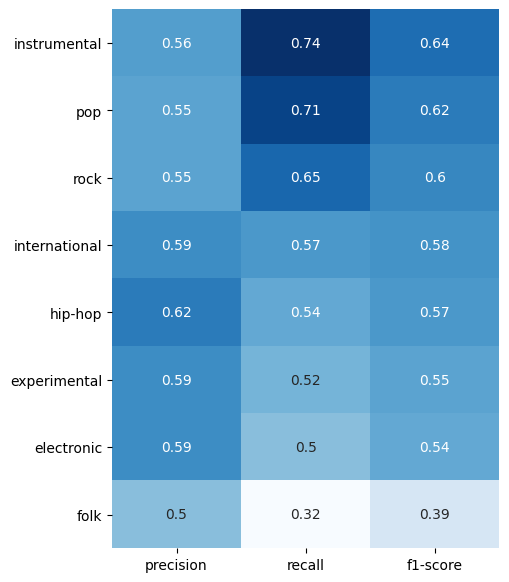

In [261]:
getPRFstats(df_majority.genre, df_majority.prediction)
plt.show()

### Combine classifications outputs to improve results

In [355]:
rfc_preds = clf_rf.predict_proba(X_test)
mlp_preds = clf_mlp.predict_proba(X_test)

### Assert label order!
assert all(clf_rf.classes_ == clf_mlp.classes_)

test_results = featureSet.iloc[X_test.index][['filename', 'genre']]
test_results['RF_MLP'] = list(zip(rfc_preds + mlp_preds))
test_results['both_pred'] = test_results['RF_MLP'].apply(lambda v: clf_rf.classes_[np.argmax(v, axis=1)][0])
test_results

,filename,genre,RF_MLP,both_pred
39833,105683.wav,hip-hop,"([0.04113895823952695, 0.04697270474930207, 0....",hip-hop
76272,052044.wav,pop,"([0.03607496887749837, 0.3046613292642083, 0.4...",pop
86603,028484.wav,pop,"([0.0648422315733067, 0.0449751382070326, 0.05...",pop
2658,113026.wav,pop,"([0.26771756811302816, 0.5855623419771314, 0.0...",experimental
43102,145059.wav,experimental,"([0.04886065912429198, 1.5904041062020289, 0.0...",experimental
...,...,...,...,...
96960,094099.wav,rock,"([0.02856502276173012, 0.07828310320953817, 0....",rock
92274,129883.wav,international,"([0.3623708568659658, 0.29811862389668176, 0.0...",electronic
23457,129879.wav,international,"([0.38859752597054975, 0.05928323739869697, 0....",international
77475,127866.wav,international,"([0.025124410544399615, 0.0865193118667941, 0....",international


In [358]:
test_results_majority = test_results.groupby(['filename', 'genre'])['both_pred'].apply(getMajority).reset_index()
test_results_majority

,filename,genre,both_pred
0,026583.wav,experimental,instrumental
1,026600.wav,experimental,experimental
2,026605.wav,experimental,experimental
3,026629.wav,electronic,electronic
4,026638.wav,rock,rock
...,...,...,...
6709,154308.wav,hip-hop,hip-hop
6710,154309.wav,hip-hop,hip-hop
6711,154413.wav,pop,pop
6712,154414.wav,pop,pop


In [411]:
acc = metrics.accuracy_score(test_results_majority.genre, test_results_majority.both_pred) * 100
print('Model combination accuracy: ', acc.round(2), '%', sep='')

Model combination accuracy: 93.98%


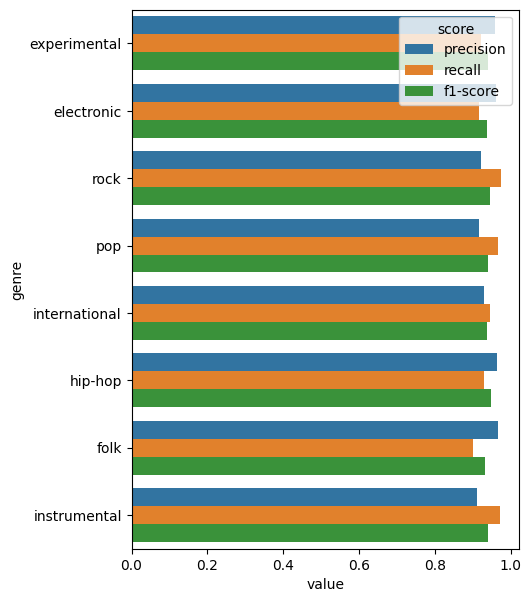

In [404]:
test_results_majority_stats = metrics.classification_report(test_results_majority.genre, test_results_majority.both_pred, target_names=labels, output_dict=True, digits=3)
res = []
for genre in labels:
    for score in test_results_majority_stats[genre]:
        if score == 'support': continue
        entry = {'genre': genre, 'score': score, 'value': test_results_majority_stats[genre][score]}      
        res.append(entry)
test_results_majority_stats = pd.DataFrame(res)
plt.figure(figsize=(5, 7));
sns.barplot(x='value', y='genre', hue='score', data=test_results_majority_stats)
plt.show()

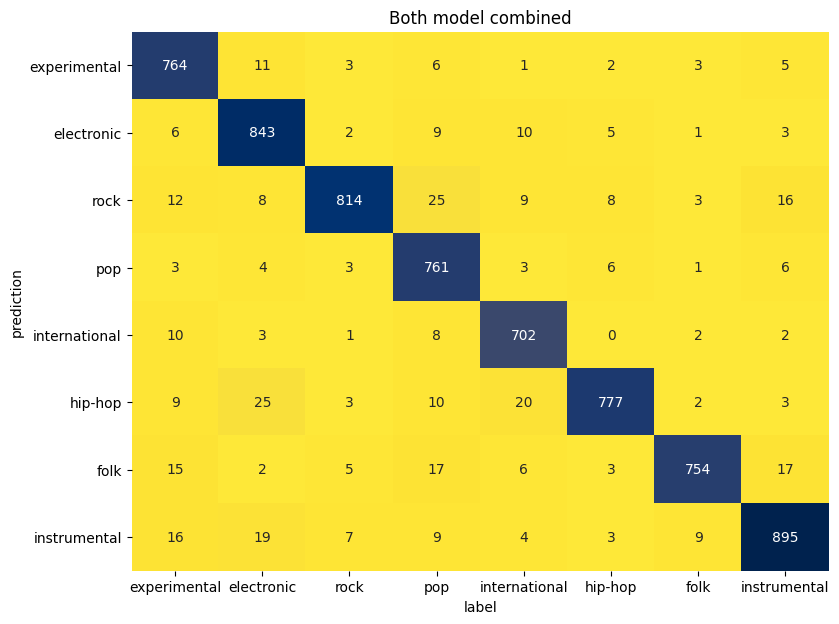

In [362]:
getConfusionMatrix('Both model combined', test_results_majority.genre, test_results_majority.both_pred)